In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import sys
sys.path.append("../scripts")

In [15]:
%%writefile "../scripts/utils.py"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import progressbar
import time

class ProgressBar:
    def __init__(self, max_value):
        time.sleep(0.5)
        self.bar = progressbar.ProgressBar(
            min_value=0,
            max_value=max_value,
            initial_value=0,
            widgets = [progressbar.SimpleProgress(), 
                       progressbar.Bar(), 
                       progressbar.Percentage()])
        self.bar.update(0)
        self.counter = 0
    
    def update(self):
        self.bar.update(self.counter + 1)
        self.counter += 1
        
    def finish(self):
        self.bar.finish()       

def flatten(x):
    return [z for y in x for z in y]

def plot_grid(df, n_cols, figsize):
    n_rows = int(np.ceil(len(df.columns)/n_cols))
    df.plot(subplots=True, layout=(n_rows, n_cols), figsize=figsize)

def plot_fcst(fcst, train=None, test=None, ax=None):
    lower = fcst.yhat_lower.interpolate()
    upper = fcst.yhat_upper.interpolate()
    if ax is None:
        f, ax = plt.subplots(1, 1)
    if train is not None:
        train.plot(style="k.", ax=ax)
    if test is not None:
        test.plot(style="r.", ax=ax)
    fcst.yhat.plot(ax=ax)
    ax.fill_between(fcst.index, y1=lower, y2=upper, alpha=0.3)

def get_amount_info(df):
    amount_info = df.notna().sum().sort_values() / len(df)
    return amount_info

def get_forecastables(df, T=0.5, N=None):
    amount_info = get_amount_info(df)
    forecastable = (amount_info > T)
    if N is not None:
        forecastable = forecastable.tail(N)
    return df.loc[:, forecastable.index].copy()


Overwriting ../scripts/utils.py


In [231]:
%%writefile "../scripts/forecaster.py"

import numpy as np
import pandas as pd
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters()
import pmdarima as pm
from utils import ProgressBar

class ProphetForecaster:
    def __init__(
        self, 
        use_boxcox=True,
        yearly_seasonality="auto",
        weekly_seasonality=False,
        daily_seasonality=False,
        confidence_interval=0.8,
        **kwargs):
        
        self.models = dict()
        self.fcst = dict()
        self.lmbda_boxcox = dict()
        self.use_boxcox = use_boxcox
        self.yearly_seasonality = yearly_seasonality
        self.weekly_seasonality = weekly_seasonality
        self.daily_seasonality = daily_seasonality
        self.prophet_config = kwargs

    def fit(self, train_df):
        print("Fitting...")
        progress_bar = ProgressBar(len(train_df.columns))
        
        for item in train_df.columns:
            target = train_df[item].dropna()
            if self.use_boxcox:
                idx = target.index
                target, self.lmbda_boxcox[item] = boxcox(target)
                target = pd.Series(target, index=idx)
            target.index.name = "ds"
            target.name = "y"
            target = target.reset_index()
            self.models[item] = Prophet(
                yearly_seasonality=self.yearly_seasonality,
                weekly_seasonality=self.weekly_seasonality,
                daily_seasonality=self.daily_seasonality,
                **self.prophet_config)
            self.models[item].fit(target)
            progress_bar.update()
        progress_bar.finish()
        return self.models
            
    def predict(self, steps, freq="D"):
        print("Forecasting...")
        progress_bar = ProgressBar(len(self.models.items()))
        for item, model in self.models.items():
            future = model.make_future_dataframe(steps, freq=freq)
            pred = model.predict(future).set_index("ds")
            pred = pred[["yhat", "yhat_lower", "yhat_upper"]]
            self.fcst[item] = pred
            if self.use_boxcox:
                self.fcst[item] = inv_boxcox(
                    self.fcst[item], 
                    self.lmbda_boxcox[item])
            progress_bar.update()
        progress_bar.finish()
        fcst_df = pd.concat(self.fcst, axis=1).sort_index(axis=1)
        return fcst_df

class ARIMAForecaster:
    def __init__(
        self,
        use_boxcox=True,
        n_fourier_terms=10,
        seasonality=[365.25],
        confidence_interval=0.8,
        **kwargs):
    
        self.models = dict()
        self.fcst = dict()
        self.lmbda_boxcox = dict()
        self.use_boxcox = use_boxcox
        self.n_fourier_terms = n_fourier_terms
        self.seasonality = seasonality
        self.confidence_interval = confidence_interval
        self.arima_config = kwargs

    def fit(self, train_df):
        self.train_ds = train_df.index
        print("Fitting...")
        progress_bar = ProgressBar(len(train_df.columns))
        for item in train_df.columns:
            target = train_df[item].interpolate().bfill()
            if self.use_boxcox:
                idx = target.index
                target, self.lmbda_boxcox[item] = boxcox(target)
                target = pd.Series(target, index=idx)
            self.models[item] = pm.auto_arima(
                target,
                seasonal=False,
                exogenous=fourier(
                    len(target), 
                    seasonality=self.seasonality, 
                    n_terms=self.n_fourier_terms), 
                method="bfgs",
                suppress_warnings=True,
                **self.arima_config)
            progress_bar.update()
        progress_bar.finish()
        return self.models
            
    def predict(self, steps):
        print("Forecasting...")
        progress_bar = ProgressBar(len(self.models.items()))
        self.fcst_ds = pd.date_range(
            start=self.train_ds.min(), 
            freq="D", 
            periods=len(self.train_ds)+steps)[-365:]
        for item, model in self.models.items():
            pred = model.predict(
                exogenous=fourier(
                    steps, 
                    seasonality=self.seasonality, 
                    n_terms=self.n_fourier_terms),
                n_periods=steps, 
                return_conf_int=True,
                alpha=(1.0 - self.confidence_interval))
            self.fcst[item] = pd.DataFrame(
                {"yhat":pred[0],
                 "yhat_lower":pred[1][:,0],
                 "yhat_upper":pred[1][:,1]},
                index=self.fcst_ds)
            if self.use_boxcox:
                self.fcst[item] = inv_boxcox(
                    self.fcst[item], 
                    self.lmbda_boxcox[item])
            progress_bar.update()
        progress_bar.finish()
        return pd.concat(self.fcst, axis=1)
    
def fourier(steps, seasonality, n_terms=10):
    coeff_list = []
    t = np.arange(0, steps)
    for period in seasonality:
        coeff_M = np.zeros((steps, 2*n_terms))
        for k in range(n_terms):
            coeff_M[:, 2*k] = np.sin(2*np.pi*(k+1)*t/period)
            coeff_M[:, 2*k+1] = np.cos(2*np.pi*(k+1)*t/period)
        coeff_list.append(coeff_M)
    coeff = np.concatenate(coeff_list, axis=1)
    return coeff

Overwriting ../scripts/forecaster.py


In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils

In [63]:
plt.rcParams["figure.figsize"] = (14,4)

In [64]:
data = pd.read_csv("../data/base_limpia.csv", parse_dates=["tiempo", "fecha pedido", "fecha liq"])

In [65]:
data.head()

,tiempo,nro factura,cliente,categoria,tipo negocio,localidad,direccion,plaza/campaña,producto,nro pedido,...,u pedidas,kg pedidos,fecha liq,u entregadas,kg entregados,importe bruto,importe factura,sucursal,longitud,latitud
0,2017-05-29,93315173,200008870,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2736812,...,1,1.250,2017-05-29,1,1.250,231.70,12421.88,santa fe,-60.691979,-31.602638
1,2017-06-14,93368453,200008870,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2765668,...,1,1.250,2017-06-14,1,1.250,231.70,19944.84,santa fe,-60.691979,-31.602638
2,2017-02-21,93074208,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90740,2546672,...,2,1.464,2017-02-21,2,1.464,324.96,24534.07,santa fe,-60.686356,-31.620964
3,2017-05-11,93270490,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2702464,...,1,1.250,2017-05-11,1,1.250,231.70,27204.63,santa fe,-60.686356,-31.620964
4,2017-05-24,93309184,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2732609,...,1,1.250,2017-05-24,1,1.250,231.70,16573.12,santa fe,-60.686356,-31.620964


# Forecast por producto

In [232]:
u_producto = pd.pivot_table(
    data, 
    values="u pedidas", 
    index="tiempo", 
    columns="producto", 
    aggfunc="sum").asfreq("D")

In [233]:
u_producto.head()

producto,16034,16061,16062,16070,16071,16075,16076,16077,16080,16081,...,44151,44152,44154,44155,44157,44158,90739,90740,90745,90746
tiempo,,,,,,,,,,,,,,,,,,,,,
2017-01-02,NaN,7.0,1.0,25.0,11.0,3.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,4.0,1.0,NaN,NaN
2017-01-03,NaN,21.0,NaN,27.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN
2017-01-04,NaN,NaN,NaN,8.0,4.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
2017-01-05,NaN,3.0,NaN,6.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.0,NaN,1.0,NaN,1.0,NaN,NaN
2017-01-06,NaN,NaN,2.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [234]:
u_producto = u_producto.reindex(index=pd.date_range(start="2017-01-01", end="2019-12-31", freq="D"))

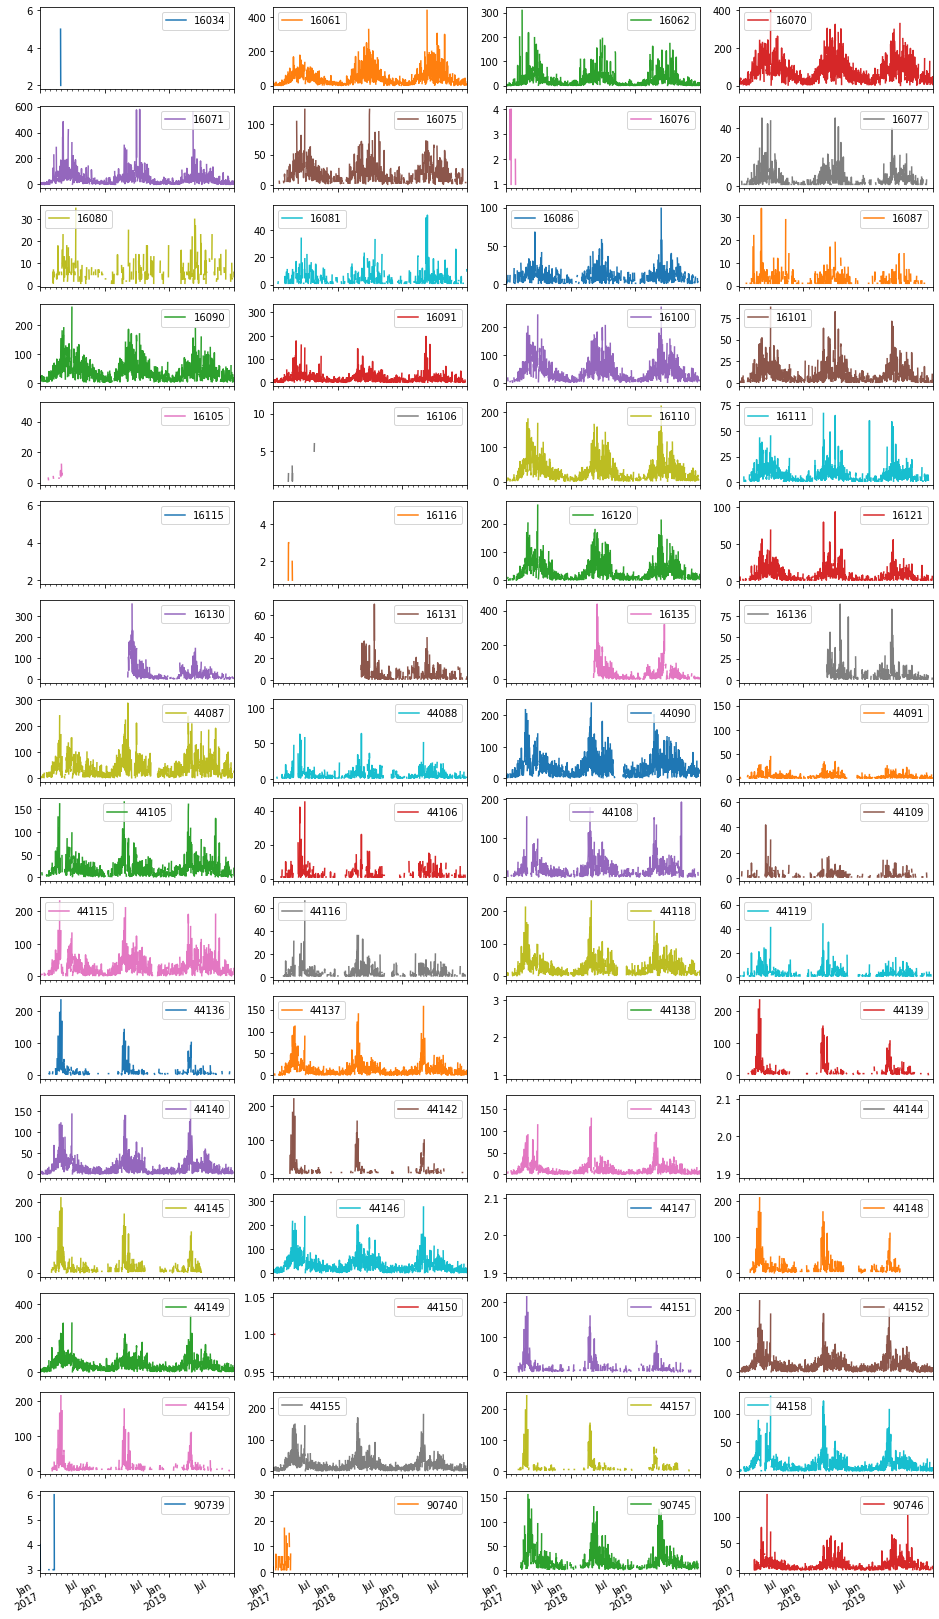

In [235]:
utils.plot_grid(u_producto, n_cols=4, figsize=(16,32))

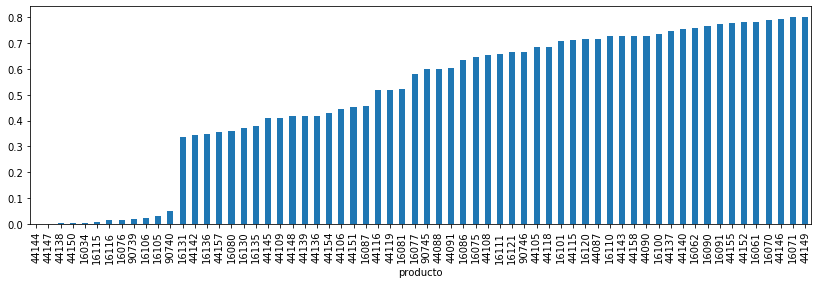

In [236]:
utils.get_amount_info(u_producto).plot(kind="bar")

In [237]:
u_producto_forecastable = utils.get_forecastables(u_producto, T=0.5, N=6)

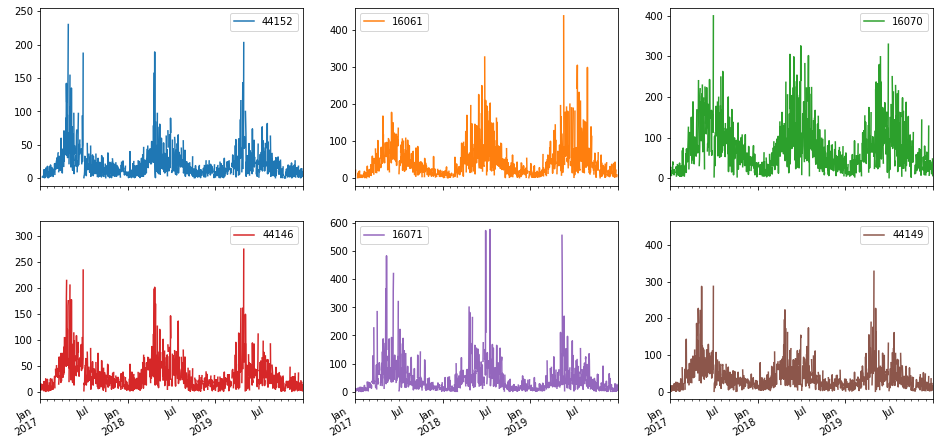

In [238]:
utils.plot_grid(u_producto_forecastable, n_cols=3, figsize=(16, 8))

In [239]:
train, test = u_producto_forecastable[:"2018-12-31"], u_producto_forecastable["2019-01-01":]

### Prophet

In [240]:
from forecaster import ProphetForecaster

In [241]:
model = ProphetForecaster(yearly_seasonality=10)
model.fit(train)
fcst = model.predict(steps=365).asfreq("D")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


In [245]:
fcst.head(10)

16061                            16070                        \
                yhat yhat_lower yhat_upper       yhat yhat_lower yhat_upper   
ds                                                                            
2017-01-02  7.607492   2.201787  21.073711  18.882908   5.489982  48.205988   
2017-01-03  7.655358   2.077498  20.942097  18.468423   4.969016  45.742053   
2017-01-04       NaN        NaN        NaN  18.132702   5.024296  49.190920   
2017-01-05  7.752606   2.049075  21.486776  17.871038   4.940853  44.646197   
2017-01-06       NaN        NaN        NaN  17.677949   4.967259  45.708047   
2017-01-07  7.819204   2.066125  21.769107  17.547252   4.953226  45.308421   
2017-01-08       NaN        NaN        NaN        NaN        NaN        NaN   
2017-01-09       NaN        NaN        NaN        NaN        NaN        NaN   
2017-01-10       NaN        NaN        NaN  17.458311   4.412300  46.307870   
2017-01-11  7.730956   1.976719  21.483970  17.503271   4.568769  44.571705   

               16071                           44146                        \
                yhat yhat_lower yhat_upper      yhat yhat_lower yhat_upper   
ds                                                                           
2017-01-02  7.443757   2.324000  24.761773  8.136911   2.483178  22.124669   
2017-01-03  7.226782   1.877005  21.805537  7.933868   2.625046  21.369297   
2017-01-04  7.029426   2.009006  23.738688  7.758169   2.579991  21.121240   
2017-01-05  6.852098   1.831062  22.063904  7.610907   2.446967  19.784696   
2017-01-06       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-07  6.557927   1.625918  20.529028  7.404455   2.121421  19.342856   
2017-01-08       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-09  6.342950   1.625654  22.245806       NaN        NaN        NaN   
2017-01-10  6.263923   1.623473  19.186010  7.317735   2.154935  19.436323   
2017-01-11  6.202888   1.786886  20.870938  7.347116   2.148001  18.301778   

               44149                           44152                        
                yhat yhat_lower yhat_upper      yhat yhat_lower yhat_upper  
ds                                                                          
2017-01-02  9.402126   2.546357  25.354858       NaN        NaN        NaN  
2017-01-03  9.200642   2.656321  24.189431       NaN        NaN        NaN  
2017-01-04  9.033849   2.427757  25.512378       NaN        NaN        NaN  
2017-01-05  8.901382   2.618644  25.616952       NaN        NaN        NaN  
2017-01-06  8.802618   2.332924  23.719561       NaN        NaN        NaN  
2017-01-07  8.736705   2.340166  23.227717       NaN        NaN        NaN  
2017-01-08       NaN        NaN        NaN       NaN        NaN        NaN  
2017-01-09       NaN        NaN        NaN       NaN        NaN        NaN  
2017-01-10  8.724281   2.626592  25.396202       NaN        NaN        NaN  
2017-01-11  8.776896   2.326804  24.741524  4.718857   1.290711  13.162431

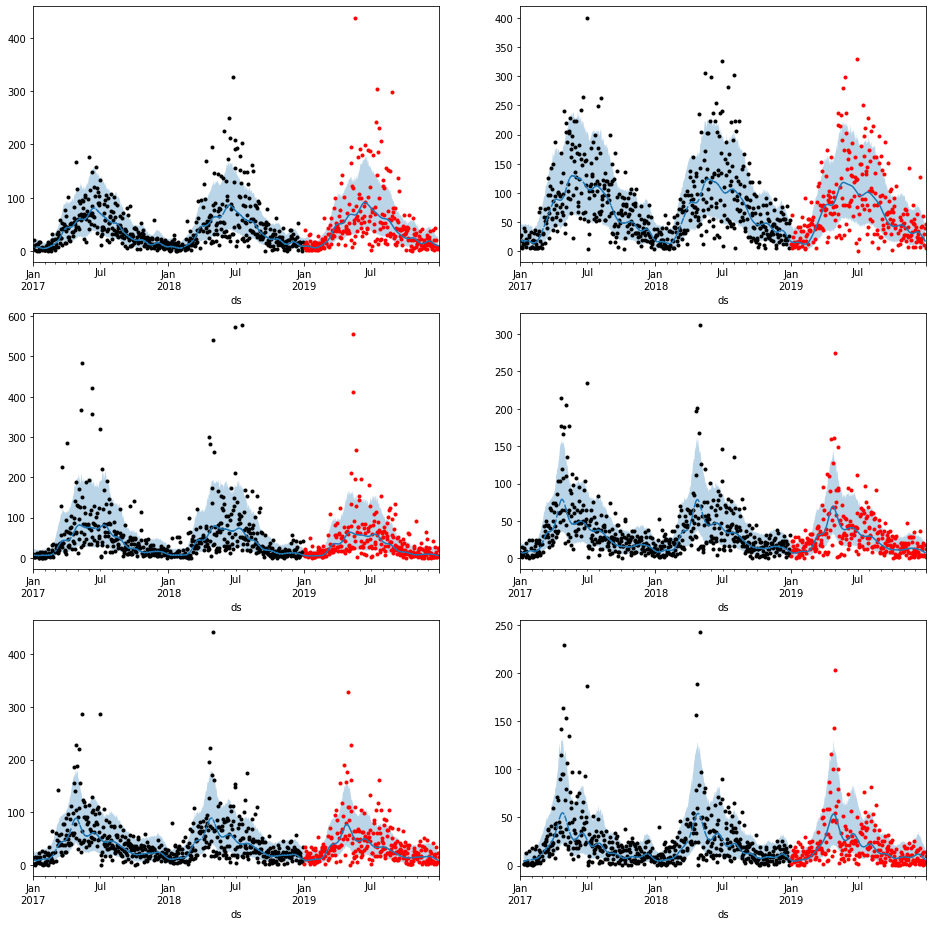

In [243]:
f, axs = plt.subplots(3, 2, figsize=(16,16))
items = fcst.columns.get_level_values(0).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

In [244]:
error_prophet = fcst.loc["2019-01-01":"2019-12-31", pd.IndexSlice[:,"yhat"]].droplevel(1, axis=1) - test
mae_prophet = error_prophet.abs().mean().mean()
mae_prophet

21.90551568820652

### ARIMA

In [105]:
from forecaster import ARIMAForecaster

In [158]:
model = ARIMAForecaster()
model.fit(train)
fcst = model.predict(365)

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


In [159]:
fcst.head(10)

44152                           16061                        \
                yhat yhat_lower yhat_upper      yhat yhat_lower yhat_upper   
2019-01-01  5.610312   1.863951  14.906400  8.844467   2.886348  22.272293   
2019-01-02  3.938830   1.226000  11.012163  8.836211   2.883019  22.254834   
2019-01-03  3.604491   1.107513  10.178921  8.834330   2.882260  22.250857   
2019-01-04  4.028328   1.246324  11.315113  8.833912   2.882092  22.249972   
2019-01-05  4.426788   1.380743  12.356490  8.830068   2.880542  22.241843   
2019-01-06  4.434203   1.382940  12.377991  8.818091   2.875713  22.216510   
2019-01-07  4.229539   1.309993  11.870341  8.793622   2.865852  22.164740   
2019-01-08  3.991969   1.225705  11.279295  8.752824   2.849421  22.078380   
2019-01-09  3.831378   1.169234  10.876770  8.692549   2.825174  21.950695   
2019-01-10  3.751256   1.141222  10.674973  8.610484   2.792214  21.776667   

                16070                            44146                        \
                 yhat yhat_lower yhat_upper       yhat yhat_lower yhat_upper   
2019-01-01  23.047420   7.535104  54.259896  12.444384   4.504883  29.544891   
2019-01-02  20.023722   6.153331  48.856621  10.225256   3.507979  25.230683   
2019-01-03  19.537596   5.948147  47.924097   9.824683   3.343335  24.382504   
2019-01-04  19.116768   5.771664  47.113877   9.443966   3.187898  23.572519   
2019-01-05  18.759386   5.622640  46.423593   9.087350   3.043263  22.810234   
2019-01-06  18.462698   5.499531  45.848949   8.758416   2.910715  22.103902   
2019-01-07  18.223150   5.400540  45.383904   8.460083   2.791238  21.460479   
2019-01-08  18.036479   5.323657  45.020834   8.194630   2.685543  20.885633   
2019-01-09  17.897794   5.266685  44.750705   7.963753   2.594101  20.383795   
2019-01-10  17.801652   5.227264  44.563244   7.768621   2.517179  19.958252   

                16071                            44149                        
                 yhat yhat_lower yhat_upper       yhat yhat_lower yhat_upper  
2019-01-01  14.021466   4.493182  38.562175  14.877593   5.058075  36.178896  
2019-01-02  11.100428   3.383485  31.753886  12.583454   4.045060  31.772726  
2019-01-03   9.604403   2.854448  28.021480  11.929210   3.781779  30.400108  
2019-01-04   8.924191   2.623508  26.258768  11.530368   3.623591  29.553665  
2019-01-05   8.446119   2.463197  25.006772  11.193755   3.490988  28.836027  
2019-01-06   8.060103   2.334710  23.989842  10.891437   3.372600  28.188977  
2019-01-07   7.720177   2.222233  23.090187  10.620091   3.266924  27.606112  
2019-01-08   7.414207   2.121543  22.276974  10.379915   3.173860  27.088485  
2019-01-09   7.138447   2.031259  21.541142  10.171424   3.093442  26.637796  
2019-01-10   6.891984   1.950953  20.881042   9.994975   3.025657  26.255369

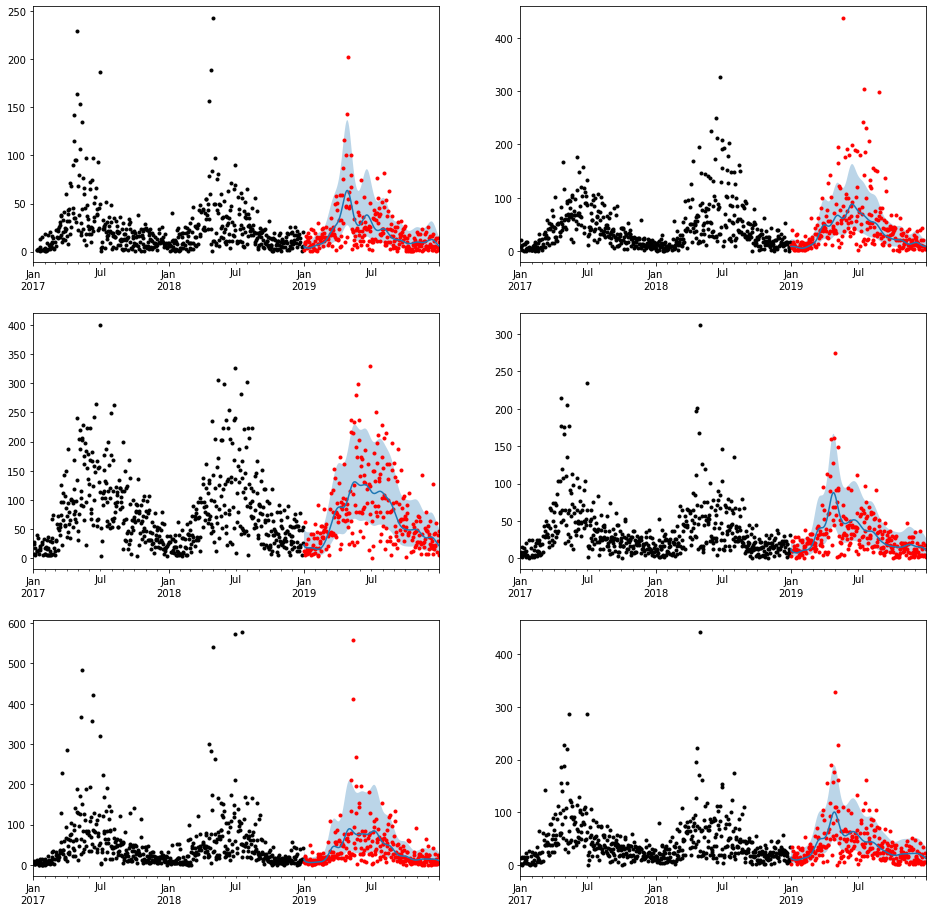

In [160]:
f, axs = plt.subplots(3, 2, figsize=(16,16))
items = fcst.columns.get_level_values(0).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

In [161]:
error_arima = fcst.loc[:, pd.IndexSlice[:,"yhat"]].droplevel(1, axis=1) - test
mae_arima = error_arima.abs().mean().mean()
mae_arima

22.16739330886189

# Forecast por producto y región

In [187]:
u_producto_region = pd.pivot_table(
    data, 
    values="u pedidas", 
    index="tiempo", 
    columns=["producto", "sucursal"], 
    aggfunc="sum").asfreq("D")

In [188]:
u_producto_region = u_producto_region.reindex(index=pd.date_range(start="2017-01-01", end="2019-12-31", freq="D"))

In [189]:
u_producto_region.head()

producto      16034   16061            16062            16070           \
sucursal   santa fe neuquen santa fe neuquen santa fe neuquen santa fe   
2017-01-01      NaN     NaN      NaN     NaN      NaN     NaN      NaN   
2017-01-02      NaN     NaN      7.0     NaN      1.0     NaN     25.0   
2017-01-03      NaN     NaN     21.0     NaN      NaN     NaN     27.0   
2017-01-04      NaN     NaN      NaN     NaN      NaN     NaN      8.0   
2017-01-05      NaN     NaN      3.0     NaN      NaN     NaN      6.0   

producto     16071            16075  ...   44158            90739           \
sucursal   neuquen santa fe neuquen  ... neuquen santa fe neuquen santa fe   
2017-01-01     NaN      NaN     NaN  ...     NaN      NaN     NaN      NaN   
2017-01-02     NaN     11.0     NaN  ...     NaN      NaN     NaN      4.0   
2017-01-03     NaN      2.0     NaN  ...     NaN      NaN     NaN      3.0   
2017-01-04     NaN      4.0     NaN  ...     NaN      1.0     NaN      NaN   
2017-01-05     NaN      3.0     NaN  ...     NaN      1.0     NaN      NaN   

producto     90740            90745            90746           
sucursal   neuquen santa fe neuquen santa fe neuquen santa fe  
2017-01-01     NaN      NaN     NaN      NaN     NaN      NaN  
2017-01-02     NaN      1.0     NaN      NaN     NaN      NaN  
2017-01-03     NaN      2.0     NaN      NaN     NaN      NaN  
2017-01-04     NaN      NaN     NaN      NaN     NaN      NaN  
2017-01-05     NaN      1.0     NaN      NaN     NaN      NaN  

[5 rows x 120 columns]

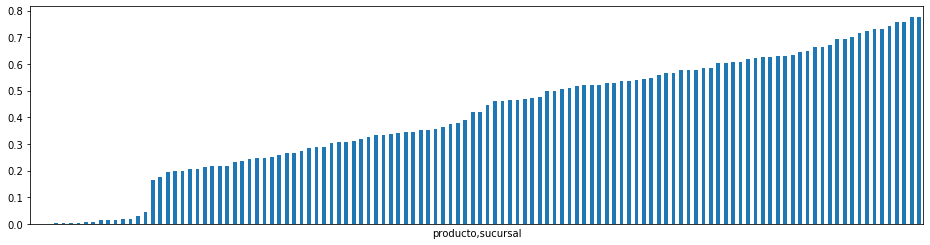

In [190]:
utils.get_amount_info(u_producto_region).plot(kind="bar", figsize=(16,4))
plt.xticks(ticks=[]);

In [191]:
u_producto_region_forecastable = utils.get_forecastables(u_producto_region, T=0.5, N=12).sort_index(axis=1)

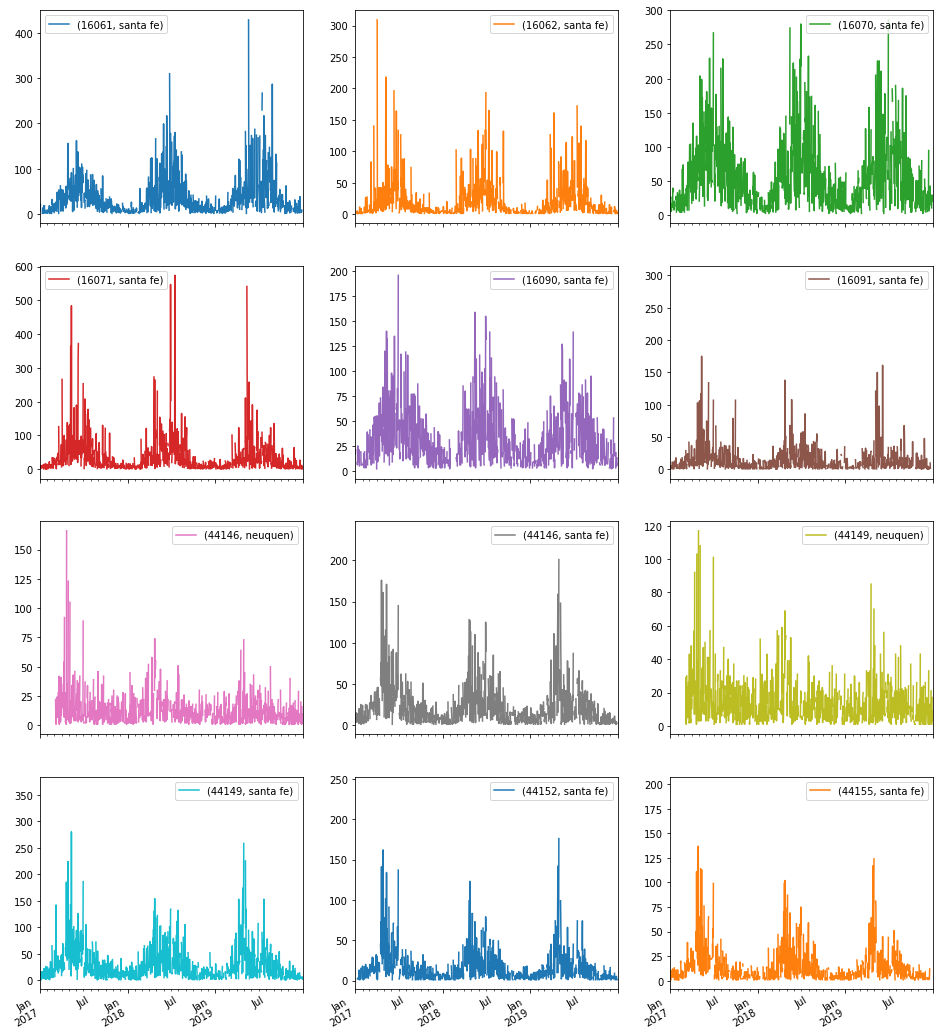

In [192]:
utils.plot_grid(u_producto_region_forecastable, n_cols=3, figsize=(16, 20))

In [193]:
train, test = u_producto_region_forecastable[:"2018-12-31"], u_producto_region_forecastable["2019-01-01":]

### Prophet

In [214]:
model = ProphetForecaster(yearly_seasonality=True)
model.fit(train)
fcst = model.predict(steps=365).asfreq("D")

Fitting...


12 of 12|#################################################################|100%


Forecasting...


12 of 12|#################################################################|100%


In [219]:
fcst.head(10)

16061                           16062                        \
            santa fe                        santa fe                         
                yhat yhat_lower yhat_upper      yhat yhat_lower yhat_upper   
ds                                                                           
2017-01-02  5.386853   1.693094  15.648718  2.229475   0.808406   6.615140   
2017-01-03  5.406998   1.458107  16.191717       NaN        NaN        NaN   
2017-01-04       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-05  5.441283   1.557167  16.469669       NaN        NaN        NaN   
2017-01-06       NaN        NaN        NaN  2.306941   0.735074   7.331255   
2017-01-07  5.456751   1.547552  16.611474       NaN        NaN        NaN   
2017-01-08       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-09       NaN        NaN        NaN  2.358351   0.828098   8.301681   
2017-01-10       NaN        NaN        NaN  2.370805   0.789612   7.769039   
2017-01-11  5.395641   1.796469  16.561713  2.379988   0.759625   7.260850   

                16070                           16071  ...      44149  \
             santa fe                        santa fe  ...    neuquen   
                 yhat yhat_lower yhat_upper      yhat  ... yhat_upper   
ds                                                     ...              
2017-01-02  14.953977   4.634395  41.460101  5.567765  ...        NaN   
2017-01-03  14.656313   4.411914  37.773745  5.496262  ...        NaN   
2017-01-04  14.414836   4.123072  40.659688  5.432328  ...        NaN   
2017-01-05  14.227067   4.160877  37.272221  5.375307  ...        NaN   
2017-01-06  14.089813   4.053943  38.487295       NaN  ...        NaN   
2017-01-07  13.999225   4.119818  39.384332  5.279075  ...        NaN   
2017-01-08        NaN        NaN        NaN       NaN  ...        NaN   
2017-01-09        NaN        NaN        NaN  5.201425  ...        NaN   
2017-01-10  13.960102   3.833937  37.254306  5.167639  ...        NaN   
2017-01-11  14.006174   4.054249  35.797801  5.136246  ...        NaN   

                                               44152                        \
            santa fe                        santa fe                         
                yhat yhat_lower yhat_upper      yhat yhat_lower yhat_upper   
ds                                                                           
2017-01-02  7.859500   1.953322  24.098098       NaN        NaN        NaN   
2017-01-03  7.707466   2.062708  25.754764       NaN        NaN        NaN   
2017-01-04  7.570713   2.013466  24.566243       NaN        NaN        NaN   
2017-01-05  7.449867   2.025687  23.192371       NaN        NaN        NaN   
2017-01-06  7.345328   1.746411  23.746521       NaN        NaN        NaN   
2017-01-07  7.257265   1.604665  23.664122       NaN        NaN        NaN   
2017-01-08       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-09       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-10  7.090192   1.677221  22.562859       NaN        NaN        NaN   
2017-01-11  7.065153   1.949326  23.133576  3.503355   1.091973  11.471889   

               44155                        
            santa fe                        
                yhat yhat_lower yhat_upper  
ds                                          
2017-01-02  3.829905   1.269268  12.070279  
2017-01-03       NaN        NaN        NaN  
2017-01-04  3.911377   1.215870  11.856008  
2017-01-05  3.942978   1.246231  10.692248  
2017-01-06       NaN        NaN        NaN  
2017-01-07  3.979607   1.272601  12.571544  
2017-01-08       NaN        NaN        NaN  
2017-01-09       NaN        NaN        NaN  
2017-01-10  3.954297   1.343658  11.464618  
2017-01-11  3.923883   1.300515  12.451727  

[10 rows x 36 columns]

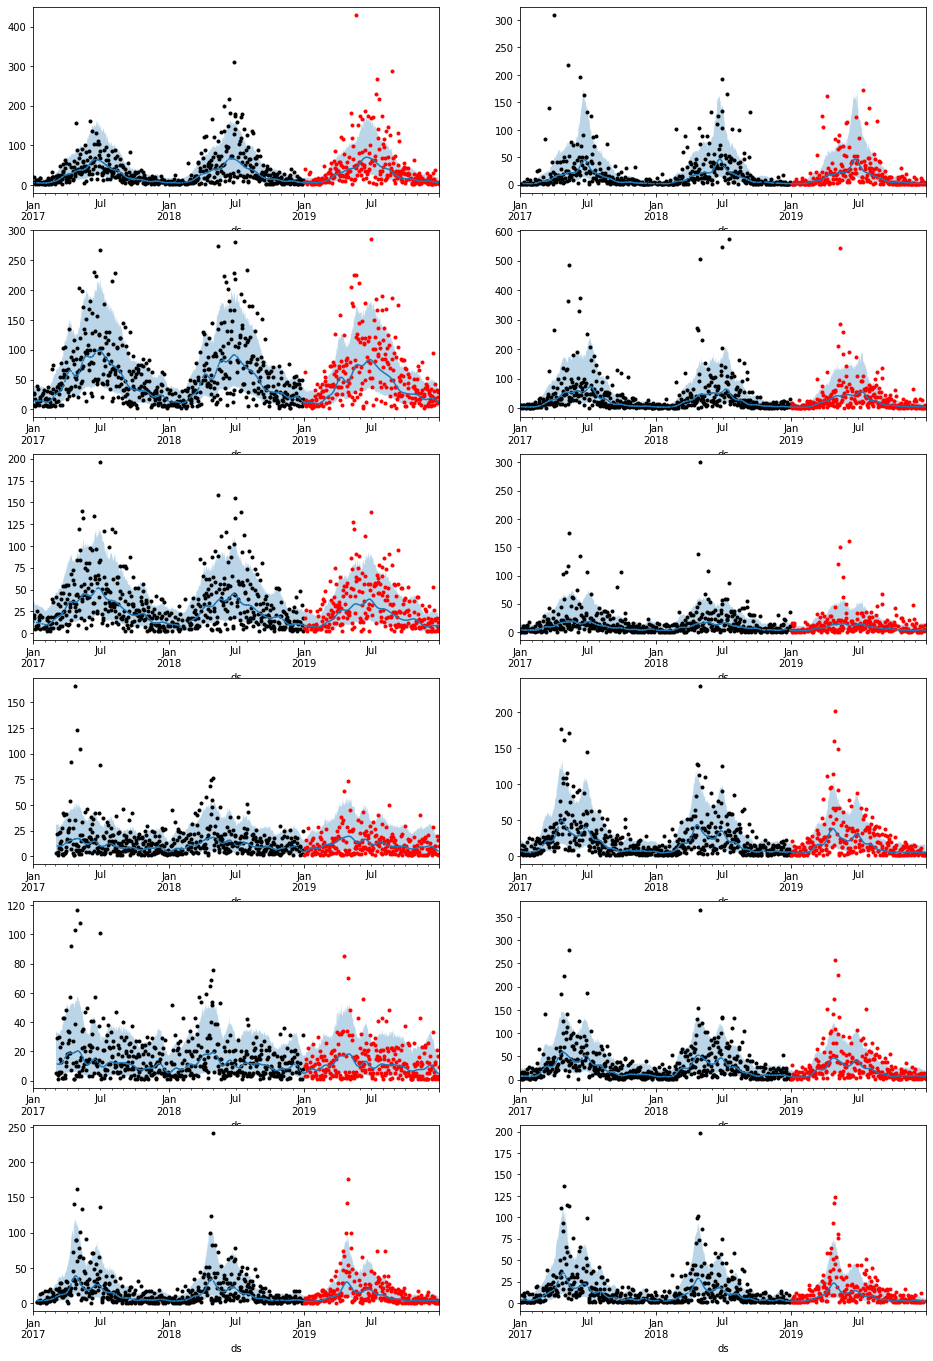

In [216]:
f, axs = plt.subplots(6, 2, figsize=(16,24))
items = fcst.columns.droplevel(2).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

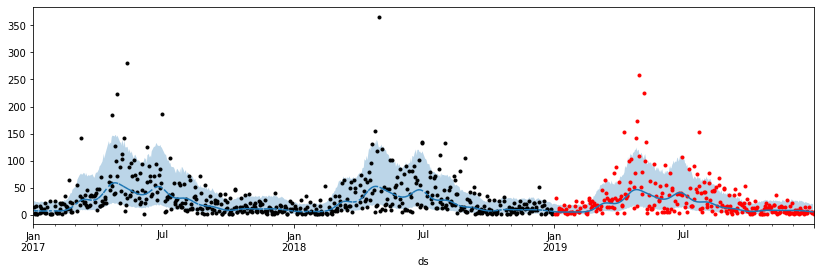

In [217]:
item = (44149, "santa fe")
utils.plot_fcst(fcst[item], train[item], test[item])

In [224]:
error_prophet = fcst.loc["2019-01-01":"2019-12-31", pd.IndexSlice[:, :,"yhat"]].droplevel(2, axis=1) - test
mae_prophet = error_prophet.abs().mean().mean()
mae_prophet

14.927661483012391

### ARIMA

In [197]:
model = ARIMAForecaster()
model.fit(train)
fcst = model.predict(365)

Fitting...


12 of 12|#################################################################|100%


Forecasting...


12 of 12|#################################################################|100%


In [199]:
fcst.head(10)

16061                           16062                        \
            santa fe                        santa fe                         
                yhat yhat_lower yhat_upper      yhat yhat_lower yhat_upper   
2019-01-01  5.807134   1.965876  15.891986  2.678196   1.015995   7.457841   
2019-01-02  5.875806   1.990966  16.067052  2.356046   0.881509   6.662935   
2019-01-03  5.947737   2.017271  16.250290  2.295836   0.859388   6.489224   
2019-01-04  6.020533   2.043916  16.435589  2.286871   0.856176   6.462679   
2019-01-05  6.091769   2.070012  16.616778  2.289289   0.857032   6.469928   
2019-01-06  6.159050   2.094680  16.787787  2.294365   0.858831   6.485121   
2019-01-07  6.220089   2.117077  16.942826  2.299714   0.860727   6.501134   
2019-01-08  6.272777   2.136422  17.076578  2.304284   0.862348   6.514819   
2019-01-09  6.315264   2.152030  17.184384  2.307334   0.863429   6.523952   
2019-01-10  6.346029   2.163337  17.262415  2.308237   0.863749   6.526655   

                16070                           16071  ...      44149  \
             santa fe                        santa fe  ...    neuquen   
                 yhat yhat_lower yhat_upper      yhat  ... yhat_upper   
2019-01-01  13.042934   4.463972  32.961447  6.576856  ...  17.305262   
2019-01-02  13.274915   4.467885  33.969412  4.180399  ...  11.923760   
2019-01-03  13.065199   4.385260  33.501031  3.879502  ...  12.189570   
2019-01-04  12.905177   4.322344  33.143083  4.565694  ...  15.820466   
2019-01-05  12.793669   4.278570  32.893367  6.182206  ...  17.765719   
2019-01-06  12.728804   4.253133  32.747996  7.168707  ...  17.991858   
2019-01-07  12.708055   4.245000  32.701479  6.968929  ...  17.485709   
2019-01-08  12.728263   4.252921  32.746784  5.818882  ...  17.272337   
2019-01-09  12.785647   4.275423  32.875393  4.886497  ...  17.441648   
2019-01-10  12.875816   4.310813  33.077356  4.473324  ...  17.805286   

                                               44152                        \
            santa fe                        santa fe                         
                yhat yhat_lower yhat_upper      yhat yhat_lower yhat_upper   
2019-01-01  8.489746   2.552761  23.978006  3.160193   1.105338   8.925575   
2019-01-02  9.484236   2.847162  26.819275  3.539637   1.206095  10.255924   
2019-01-03  9.140228   2.726355  25.970302  3.500508   1.192543  10.144365   
2019-01-04  7.862876   2.256607  22.989121  3.250473   1.098474   9.494175   
2019-01-05  6.471587   1.751533  19.752792  3.027193   1.015258   8.907959   
2019-01-06  6.149089   1.645540  18.923472  2.937690   0.984205   8.653466   
2019-01-07  6.243470   1.675193  19.177270  2.926487   0.980365   8.621205   
2019-01-08  6.522126   1.761466  19.937875  2.944785   0.986290   8.676873   
2019-01-09  6.746997   1.831686  20.547404  2.959436   0.991124   8.720662   
2019-01-10  6.767544   1.838181  20.602477  2.962741   0.992237   8.730353   

               44155                        
            santa fe                        
                yhat yhat_lower yhat_upper  
2019-01-01  2.392287   0.879474   6.541972  
2019-01-02  2.411061   0.857683   6.816307  
2019-01-03  2.471045   0.878446   6.990515  
2019-01-04  2.527583   0.896663   7.165627  
2019-01-05  2.571667   0.912217   7.291294  
2019-01-06  2.613526   0.926809   7.412046  
2019-01-07  2.652728   0.940633   7.523855  
2019-01-08  2.684845   0.951958   7.615455  
2019-01-09  2.708870   0.960426   7.684012  
2019-01-10  2.724998   0.966107   7.730061  

[10 rows x 36 columns]

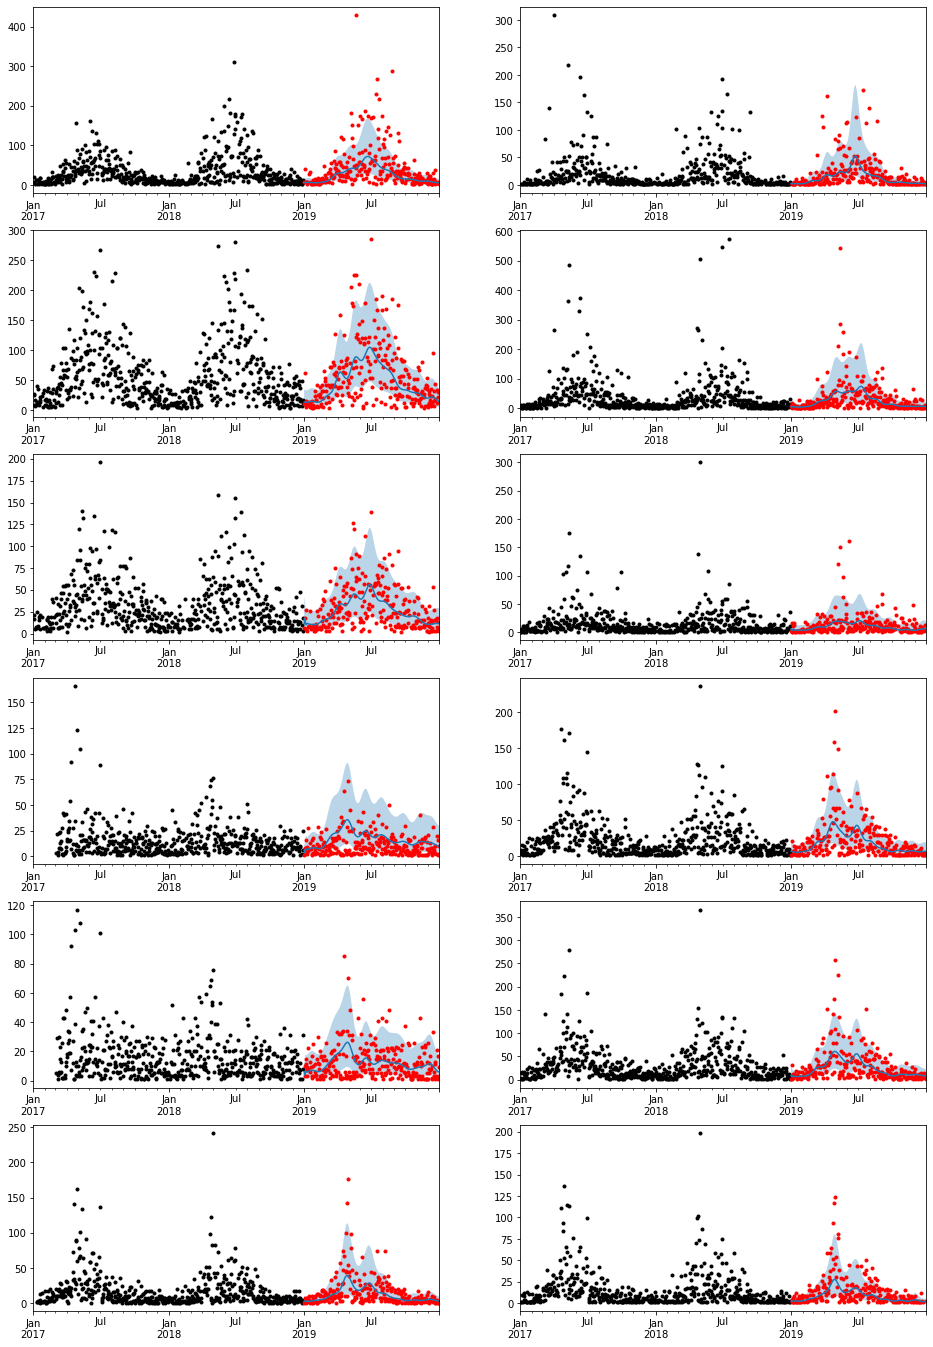

In [200]:
f, axs = plt.subplots(6, 2, figsize=(16,24))
items = fcst.columns.droplevel(2).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

In [210]:
error_arima = fcst.loc["2019-01-01":"2019-12-31", pd.IndexSlice[:, :, "yhat"]].droplevel(2, axis=1).mean() - test
mae_arima = error_arima.abs().mean().mean()
mae_arima

18.027251456999377